## Import libraries 

In [1]:
import os
import pickle 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import scipy
import scipy.cluster.hierarchy as sch

from config import (dta_dir,
                    figure_dir,
                    derived_dir,
                    core_symp2label)

## Functions 

In [2]:
def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

## Import data 

In [3]:
core_symp = pd.read_csv(dta_dir + 'llc_0028_complete_c_lca_4class_1_prev_data_v2.csv', index_col=0)
core_symp = core_symp.columns.values[:-2]

### Dict to rename symptoms 

In [4]:
labels = ['Fever', 'Cough', 'Sore throat', 'Tight chest', 
          'Difficulty breathing', 'Runny/blocked nose', 'Body/muscle aches',
          'Fatigue', 'Diarrhoea', 'Loss of smell or taste', 'Nausea or vomiting',
          'Sneezing', 'Headache', 'Difficulty concentrating','Memory loss']

In [5]:
core_symp2label = dict(zip(core_symp, labels))

## Plot 

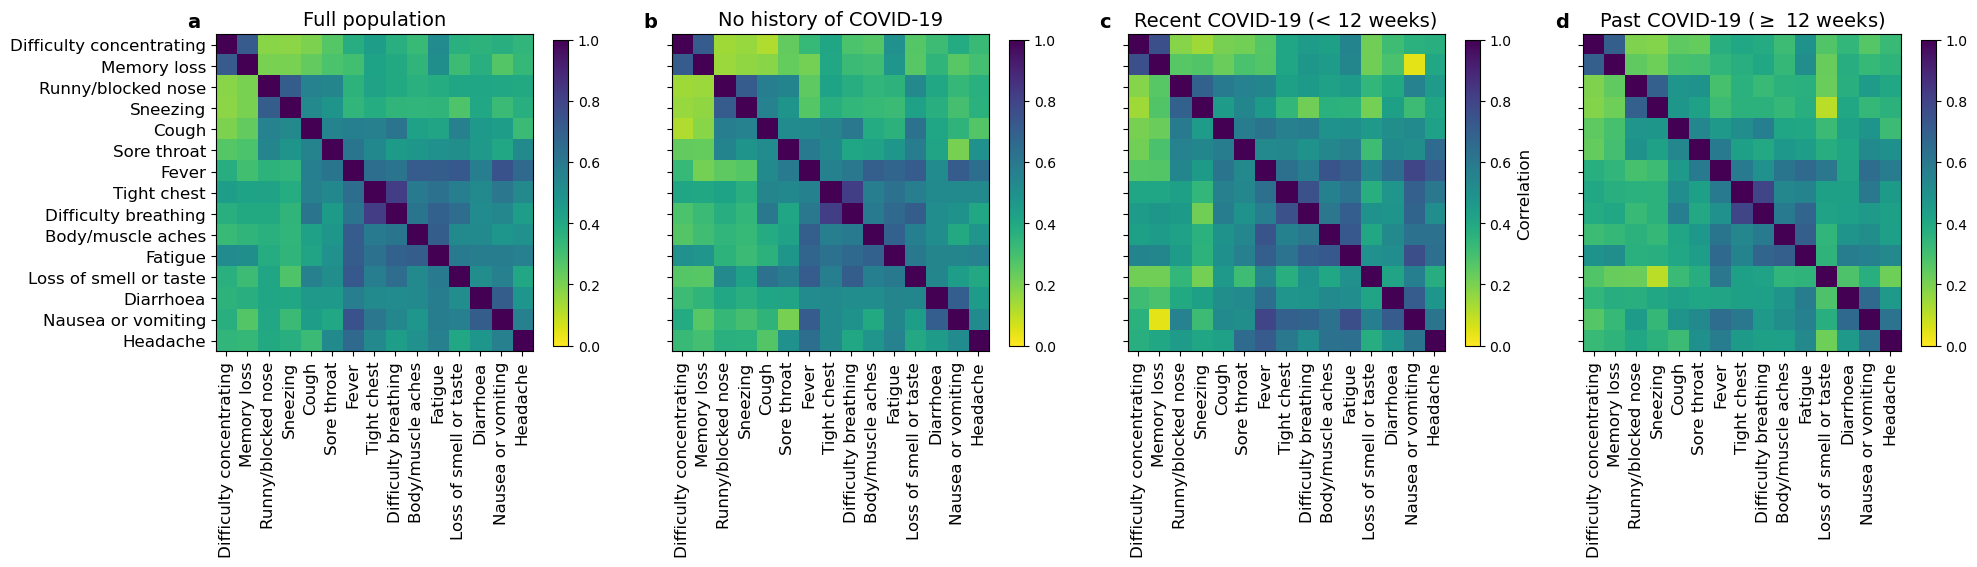

In [6]:
fig, ax_list = plt.subplots(1,4,figsize=(20,5), sharey=True)

plt.set_cmap('viridis_r')

status_list = ['all',0,1,2]
title_list = ['Full population', 'No history of COVID-19', \
              'Recent COVID-19 (< 12 weeks)', 'Past COVID-19 ($\geq$ 12 weeks)']

letters = ['a','b','c','d']

norm = mpl.colors.Normalize(vmin=0, vmax=1)

for i,status in enumerate(status_list):
    
    ax = ax_list[i]
    
    df = pd.read_csv(dta_dir + f'llc_0028_symptomcorr_{status}_data_v2.csv', index_col=0)
    
    df = df[core_symp].loc[core_symp]
    
    df = df.rename(columns=core_symp2label, index=core_symp2label)
    
    
    if i==0:
        
        cdf = cluster_corr(df)
        im = ax.imshow(cdf, norm=norm)
        cols = cdf.columns
        
        
    else:
        im = ax.imshow(df.loc[cols][cols], norm=norm)
        

    cbar = plt.colorbar(im, ax=ax, norm=norm,shrink=0.95)
    if i==2:        
        cbar.set_label('Correlation', fontsize=12)
    
    ax.set_xticks(np.arange(df.shape[1]))
    ax.set_xticklabels(cols, rotation=90, fontsize=12)
    
    ax.set_yticks(np.arange(df.shape[1]))
    ax.set_yticklabels(cols,fontsize=12)
    
    ax.set_title(title_list[i], fontsize=14)
    ax.text(-0.09, 1.02, letters[i],fontsize=14,
            fontweight='bold', transform=ax.transAxes)
    
#fig.suptitle('Symptom Correlation', fontsize=14)

plt.tight_layout()
plt.savefig(figure_dir + 'symptom_corr.pdf',bbox_inches="tight",pad_inches=0.5 )
plt.savefig(figure_dir + 'symptom_corr.png',dpi=300, bbox_inches="tight",pad_inches=0.5 )
plt.show()

### Save symptom order and dicts 

In [7]:
pd.DataFrame(cols).to_csv(derived_dir + 'sorted_columns_core.csv')

In [8]:
pickle.dump(core_symp2label, open(derived_dir + 'labeldict.pkl','wb'))

In [9]:
label2symp = dict(zip(labels,core_symp))

In [10]:
ordered_sypms = [label2symp[c] for c in cols]

In [11]:
pd.DataFrame(ordered_sypms).to_csv(derived_dir + 'sorted_columns_core_raw.csv')